## AN OPTIMIZATION OF OUTPATIENTS’ WAITING TIME AND HEALTH-RELATED RISKS

Author: Anthony Onoja (Scuola Normale Superiore di Pisa, Italy)

Date: 01/08/2022 

### Introduction

The study of optimal queuing systems in healthcare is crucial at such a time as this to help decongest the system, and minimize financial and health-related risks associated with long waiting queues. During the COVID-19 pandemic, alot of health care systems both in developed and third world countries experienced an explosion due to limited facilities and health care experts. 
Patients spent alot of time in the queuing system awaiting to access treatment at the outpatient clinic and therefore were exposed to certain financial loss, dicomfort, and health related risks. 

This study examined a queuing system at an outpatient hospital clinic post intending to minimize waiting time in association with financial cost and healthcare-related risks. We observed the queuing system using the sampling survey information of 200 outpatients that visited the clinic for 4 weeks. 

This study therefore, employs a machine learning modeling and queuing optimization models to develop a queuing modeling system to minimize outpatients’ waiting time, financial costs, and health-related risks while in the queuing system at the outpatient clinic. 

Steps to Findings: 

- Part 1: Data Explorations and Demographic Visualizations

- Part 2: Visualize relationships among variables of interest (Waiting time, Financial cost, Health-related risks)

- Part 3: Machine Learning technique - Classification phase; 

- Inference and Interpretations 

- Conclusions 

#### Load relevant libraries 

In [1]:
 # import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, label_binarize
import joblib

#### Classifier Libraries
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import make_scorer, precision_score, recall_score, classification_report
from sklearn.metrics import confusion_matrix, accuracy_score 
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import f1_score, precision_score, recall_score, fbeta_score
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
#from explainerdashboard import ClassifierExplainer, ExplainerDashboard
from sklearn.ensemble import VotingClassifier
#from explainerdashboard.datasets import titanic_survive, titanic_names
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
# import dataset for training from one fold among the 5-folds
path="/Users/Hp/Downloads/"
df = pd.read_csv(path+"waiting_time_financial_health_related_risks.csv", delimiter=',', quotechar='"')
df.head()

,sample_ID,Sex,Age,Marital_status,Level_education,Occupation,Religion,waiting_time_patient,financial_loss,Pre-existing_medical_conditions,discomfort,risk_infection
0,DTWEQ-1,Female,50 upwards,Widow,Primary,Trader,Islam,No,3000,Anemia,Tiredness,Cough
1,DTWEQ-2,Male,18-29,Single,Tertiary,Banker,Islam,Yes,3000,HIV,None,Cough
2,DTWEQ-3,Male,50 upwards,Widow,Tertiary,Teacher,Christianity,Yes,4000,Hypertension,None,None
3,DTWEQ-4,Male,18-29,Single,Secondary,Student,Christianity,No,1000,None,None,None
4,DTWEQ-5,Male,18-29,Single,Tertiary,Student,Christianity,No,3000,None,None,None


In [3]:
df.columns

Index(['sample_ID', 'Sex', 'Age', 'Marital_status', 'Level_education',
       'Occupation', 'Religion', 'waiting_time_patient', 'financial_loss',
       'Pre-existing_medical_conditions', 'discomfort', 'risk_infection'],
      dtype='object')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 12 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   sample_ID                        153 non-null    object
 1   Sex                              153 non-null    object
 2   Age                              153 non-null    object
 3   Marital_status                   153 non-null    object
 4   Level_education                  153 non-null    object
 5   Occupation                       153 non-null    object
 6   Religion                         153 non-null    object
 7   waiting_time_patient             153 non-null    object
 8   financial_loss                   153 non-null    int64 
 9   Pre-existing_medical_conditions  153 non-null    object
 10  discomfort                       153 non-null    object
 11  risk_infection                   153 non-null    object
dtypes: int64(1), object(11)
memory usage

In [5]:
df.shape

(153, 12)

In [6]:
# Checking for missing observations 
df.isnull().any()

sample_ID                          False
Sex                                False
Age                                False
Marital_status                     False
Level_education                    False
Occupation                         False
Religion                           False
waiting_time_patient               False
financial_loss                     False
Pre-existing_medical_conditions    False
discomfort                         False
risk_infection                     False
dtype: bool

In [7]:
# Checking the distribution of categorical features in the dataset 

df.describe(include=['O'])

,sample_ID,Sex,Age,Marital_status,Level_education,Occupation,Religion,waiting_time_patient,Pre-existing_medical_conditions,discomfort,risk_infection
count,153,153,153,153,153,153,153,153,153,153,153
unique,153,2,4,4,4,57,4,2,26,25,16
top,DTWEQ-32,Male,18-29,Single,Tertiary,Student,Christianity,No,None,None,None
freq,1,85,70,77,106,21,83,111,85,92,106


#### Part 1: Exploratory Data Analysis

Here we seek to understand the dataset, visualize hidden patterns and potential clues to uncover relationships. 

- visualize the dataset using violin plots 

No 72.55 % of the dataset
Yes 27.45 % of the dataset


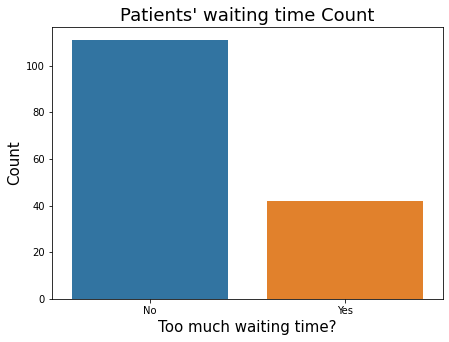

In [8]:
# Check for imbalanced classification problem in the dataset
print('No', round(df['waiting_time_patient'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Yes', round(df['waiting_time_patient'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

plt.figure(figsize=(7,5))
sns.countplot(df['waiting_time_patient'])
plt.title("Patients' waiting time Count", fontsize=18)
plt.xlabel("Too much waiting time?", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.show()

The bar chart showed the presences of imbalanced class distribution. This implies that the target dataset suffer from imbalanced classification problem, this issue will not be ignore during classification phase. We will either use resampling techniques such as SMOTE, oversampling or undersampling to or "L2" penalty and "balanced weight" of the classes in the algorithm classifiers. 

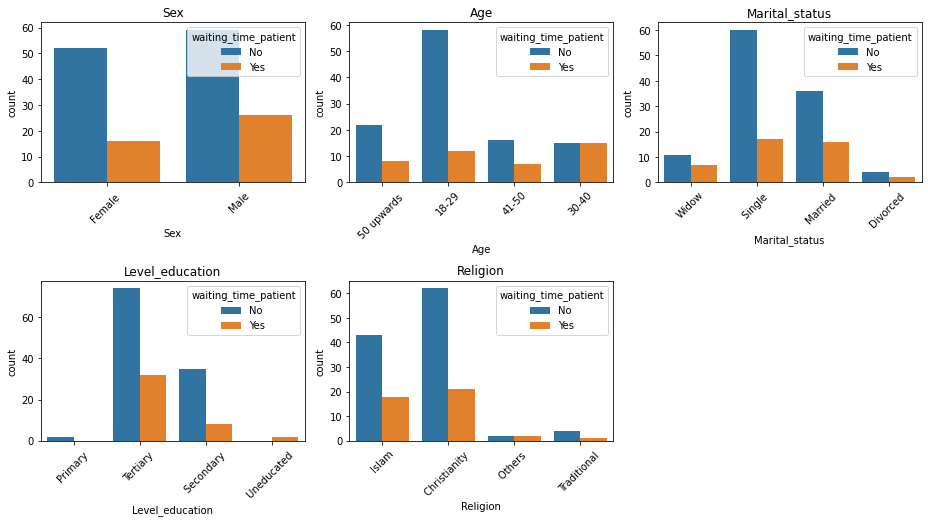

In [9]:
# Check for categorical variables 

df_1 = df[['sample_ID', 'Sex', 'Age', 'Marital_status', 'Level_education',
       'Religion', 'waiting_time_patient']]

df_1 = df_1.select_dtypes(['object'])
df_1['sample_ID'] = df['sample_ID']
c=1
fig = plt.figure(figsize=(13,8)) # Figure size to plot
for i in df_1:
  if (i != 'waiting_time_patient' and i != 'sample_ID'):
    plt.subplot(2, 3, c)
    plotCategVar = pd.DataFrame()
    plotCategVar = df[['sample_ID','waiting_time_patient',i]]
    f = plt.gca()
    f.set_title(i)
    sns.countplot(data=plotCategVar, x = i, hue = 'waiting_time_patient')
    plt.xticks(rotation=45)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    c+=1

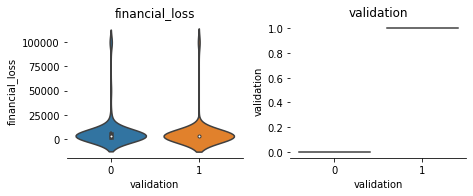

In [10]:
df_1 = df.copy()
del df_1['sample_ID']
df_1['validation'] = 0
df_1.loc[df_1.waiting_time_patient == 'No', 'validation'] = 0
df_1.loc[df_1.waiting_time_patient == 'Yes', 'validation'] = 1 # Churn
del df_1['waiting_time_patient']
df_1 = df_1.select_dtypes(['number'])
fig = plt.figure(figsize=(16,16)) # Figure size to plot
for i in range(df_1.shape[1]):
    plt.subplot(6, 5, i + 1)
    f = plt.gca()
    f.set_title(df_1.columns.values[i])
    sns.violinplot(data=df_1, x='validation', y=df_1.columns[i])
    sns.despine(left=True)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

#### Part 2: Visualize relationships among variables of interest (Waiting time, Financial cost, Health-related risks)

#### Procedures: 

- Transform all categorical features to numerical features using unique mapping to preserve feature as a single entry for quantification purposes.
- visualize via the correlation matrix for potential strong and weak associations (+1 to -1) between variables. 
- Inferences and interpretations 

In [11]:
df_1 = df.copy() # Make a copy of the original dataframe 

# Converting categorical variables to unique integers in the dataset df

# waiting time (Yes, No)
time_locs = sorted(df_1['waiting_time_patient'].unique())
time_locs_mapping = dict(zip(time_locs, range(0, len(time_locs) + 1)))
time_locs_mapping
df_1['waiting_time_patient'] = df_1['waiting_time_patient'].map(time_locs_mapping).astype(int)

# Age (Years)
age_locs = sorted(df_1['Age'].unique())
age_locs_mapping = dict(zip(age_locs, range(0, len(age_locs) + 1)))
age_locs_mapping
df_1['Age'] = df_1['Age'].map(age_locs_mapping).astype(int)

# Martial status (Single, Married, Widow, separated)
status_locs = sorted(df_1['Marital_status'].unique())
status_locs_mapping = dict(zip(status_locs, range(0, len(status_locs) + 1)))
status_locs_mapping
df_1['Marital_status'] = df_1['Marital_status'].map(status_locs_mapping).astype(int)

# Educational level (Primary, Secondary, Tertiary)
education_locs = sorted(df_1['Level_education'].unique())
education_locs_mapping = dict(zip(education_locs, range(0, len(education_locs) + 1)))
education_locs_mapping
df_1['Level_education'] = df_1['Level_education'].map(education_locs_mapping).astype(int)

# Occupation (Enginer, Farmer, Banker, etc.,)
occupation_locs = sorted(df_1['Occupation'].unique())
occupation_locs_mapping = dict(zip(occupation_locs, range(0, len(occupation_locs) + 1)))
occupation_locs_mapping
df_1['Occupation'] = df_1['Occupation'].map(occupation_locs_mapping).astype(int)

# Religion (Islam, Christianity)
religion_locs = sorted(df_1['Religion'].unique())
religion_locs_mapping = dict(zip(religion_locs, range(0, len(religion_locs) + 1)))
religion_locs_mapping
df_1['Religion'] = df_1['Religion'].map(religion_locs_mapping).astype(int)

# Pre-medical conditions (HIV, etc.,)
conditions_locs = sorted(df_1['Pre-existing_medical_conditions'].unique())
conditions_locs_mapping = dict(zip(conditions_locs, range(0, len(conditions_locs) + 1)))
conditions_locs_mapping
df_1['Pre-existing_medical_conditions'] = df_1['Pre-existing_medical_conditions'].map(conditions_locs_mapping).astype(int)

# Discomfort (headaches, tiredness, severe pain, etc.,)
discomfort_locs = sorted(df_1['discomfort'].unique())
discomfort_locs_mapping = dict(zip(discomfort_locs, range(0, len(discomfort_locs) + 1)))
discomfort_locs_mapping
df_1['discomfort'] = df_1['discomfort'].map(discomfort_locs_mapping).astype(int)

# Risk infection (Cough, cold, COVID-19, Skin rashes, etc.,)
risk_infection_locs = sorted(df_1['risk_infection'].unique())
risk_infection_locs_mapping = dict(zip(risk_infection_locs, range(0, len(risk_infection_locs) + 1)))
risk_infection_locs_mapping
df_1['risk_infection'] = df_1['risk_infection'].map(risk_infection_locs_mapping).astype(int) 

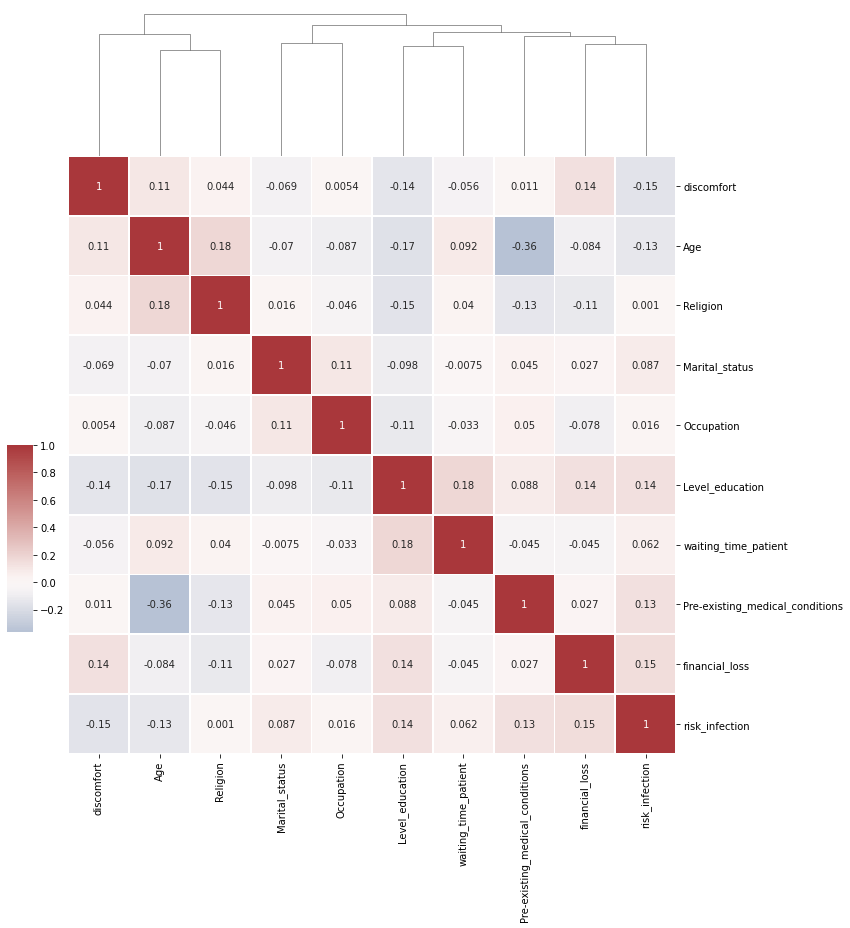

In [12]:
df_1 = df_1.drop(columns=['sample_ID'])
corrMatrix = df_1

g = sns.clustermap(corrMatrix.corr(), center=0, cmap="vlag",
                   dendrogram_ratio=(.1, .2),
                   cbar_pos=(.02, .32, .03, .2),
                   linewidths=.75, figsize=(12, 13), annot=True)
g.ax_row_dendrogram.remove()

Considering the correlation matrix above, the patient waiting time (Yes, or No) response in the descriptive questionnaire was binarized and used as the target variable to correlate with the financial and health-related risk variables. Religion and Age, waiting time and educational level have the highest positive correlation coefficient of 0.18, and pre-existing medical condition and age have the strongest negative correlation coefficient of -36. These findings reflect the true state in most African countries where religion, age, and level of education play a crucial role in our daily lives. Queuing is not an exception, for example, the Muslim community prays 5-times a day, and a long queue even in the outpatient clinic can affect a Muslim patient's daily prayer routine. 

### Part 3: Machine Learning technique - Classification phase

Here we seek to augument the proposed queuing model using traditional interpretable machine learning algorithms to classify and predict patient waiting time response (Yes, No) from a survey questionnaire issued to 200 patients in an outpatient clinic post of a public hospital. The classification model is built based on the predictors 'Sex', 'Age', 'Marital_status', 'Level_education', 'Occupation', 'Religion', 'financial_loss','Pre-existing_medical_conditions', 'discomfort', 'risk_infection'

#### Procedures:

- we first convert categorical variables to numerical variables using the dummy variable command from pandas to convert all the categories in a given categorical variable to sets of 0's and 1's. 

- We split the dataset into 80% training set and 20% testing set and; 

- standardized the dataset 

- Train the dataset with logistic regression classifier, and Random Forest classifier. 

- Validate the model using the 20% test set

- Visualize ROC curves and Feature importance 

- Interpretations of findings

- Conclusions




In [13]:
## get dummies to convert categorical variables to indicator variables (i.e., 0 or 1)
identity = df['waiting_time_patient']
sample_ID = df['sample_ID']
df = df.drop(columns=['waiting_time_patient', 'sample_ID'])

df = pd.get_dummies(df)
df = pd.concat([df, identity], axis = 1)
df = pd.concat([df, sample_ID], axis = 1)

In [14]:
df.head()

,financial_loss,Sex_Female,Sex_Male,Age_18-29,Age_30-40,Age_41-50,Age_50 upwards,Marital_status_Divorced,Marital_status_Married,Marital_status_Single,...,risk_infection_Rashes,risk_infection_Skin infection,risk_infection_Skin rash,risk_infection_Skin rashes,risk_infection_Toilet Infection,risk_infection_Tuberculosis,risk_infection_Worsening of condition,risk_infection_covid,waiting_time_patient,sample_ID
0,3000,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,No,DTWEQ-1
1,3000,0,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,Yes,DTWEQ-2
2,4000,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,Yes,DTWEQ-3
3,1000,0,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,No,DTWEQ-4
4,3000,0,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,No,DTWEQ-5


Converting the categorical variables (See table header above) into dummies will help us to ascertain the actual categories of a particular variable (feature) that posed a stronger predictive power in our model. However, this will increase the dimensionality of our dataset thereby posing risk of sparsity or overfitting of our model.

In [15]:
# Converting categorical variables to unique integers in the dataset df

time_locs = sorted(df['waiting_time_patient'].unique())
time_locs_mapping = dict(zip(time_locs, range(0, len(time_locs) + 1)))
time_locs_mapping
df['waiting_time_patient'] = df['waiting_time_patient'].map(time_locs_mapping).astype(int)


In [16]:
# define target variable 
target = df['waiting_time_patient']
df = df.drop(columns='waiting_time_patient')

In [17]:
# split dataset into 80 % and 20 % testing 
X_train, X_test, y_train, y_test = train_test_split(df, target, stratify=target, test_size = 0.2, random_state = 13)
train_identity = X_train['sample_ID']
X_train = X_train.drop(columns = ['sample_ID'])
test_identity = X_test['sample_ID']
X_test = X_test.drop(columns = ['sample_ID'])

In [18]:
# standardized the training dataset 

# training set
scale = StandardScaler()
X_train2 = pd.DataFrame(scale.fit_transform(X_train))
X_train2.columns = X_train.columns.values
X_train2.index = X_train.index.values
X_train = X_train2
# test set
X_test2 = pd.DataFrame(scale.transform(X_test))
X_test2.columns = X_test.columns.values
X_test2.index = X_test.index.values
X_test = X_test2

In [19]:
## Defined Cross-validation K-fold random Split 
from sklearn.model_selection import RepeatedKFold
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
## Logistic Regression 
lr = LogisticRegression(C=0.3, class_weight='balanced', random_state=11,solver='sag')
clf = lr
params_log = [{
    'solver': ['newton-cg', 'lbfgs', 'sag'],
    'C': [0.3, 0.5, 0.7, 1],
    'penalty': ['l2']
    },{
    'solver': ['liblinear','saga'],
    'C': [0.3, 0.5, 0.7, 1],
    'penalty': ['l1','l2']
}]
# Logistic Reg. Gridsearch CV 
cv_grid_lr = GridSearchCV(
    estimator=lr,
    param_grid=params_log,
    n_jobs=-1,
    cv = cv, 
    scoring=make_scorer(accuracy_score)
)


In [20]:
### Evaluation 
## Logistic Reg. Model 
log_reg_model_cv = cv_grid_lr.fit(X_train, y_train)

In [21]:
# Logistic Reg. Best GridSearch CV Best score 
print('Logistic Reg. Best GridSearch CV Score:', log_reg_model_cv.best_score_)

Logistic Reg. Best GridSearch CV Score: 0.6873931623931624


Test Accuracy score 0.6451612903225806
Test Matthews correlation coefficient 0.110021557355838
Test F1-score 0.35294117647058826
Test Precision score 0.375
Test Recall score 0.3333333333333333
              precision    recall  f1-score   support

           0       0.74      0.77      0.76        22
           1       0.38      0.33      0.35         9

    accuracy                           0.65        31
   macro avg       0.56      0.55      0.55        31
weighted avg       0.63      0.65      0.64        31



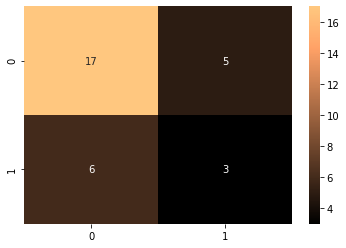

In [22]:
# predict on the 20 % test set 
y_pred = log_reg_model_cv.predict(X_test)

# Print evaluation metrics for on prediction set logistic reg. Classifier 
print('Test Accuracy score %s' % accuracy_score(y_test, y_pred))
print('Test Matthews correlation coefficient %s' % matthews_corrcoef(y_test, y_pred))
print('Test F1-score %s' % f1_score(y_test, y_pred))
print('Test Precision score %s' % precision_score(y_test, y_pred))
print('Test Recall score %s' % recall_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
confusion_matrix(y_test, y_pred)
conf_matrix = confusion_matrix(y_test,y_pred)
sns.heatmap(conf_matrix, annot=True,fmt='d', cmap=plt.cm.copper)
plt.show()

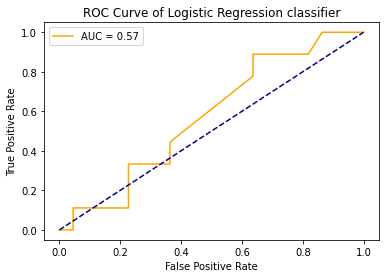

In [23]:
# Now plot the ROC curve for Logistic regression 
probs = log_reg_model_cv.predict_proba(X_test)
probs = probs[:, 1]
auc1 = roc_auc_score(y_test, probs)
fpr1, tpr1, thresholds = roc_curve(y_test, probs)
def plot_roc_curve(fpr1, tpr1):
    plt.plot(fpr1, tpr1, color='orange', label = 'AUC = %0.2f' % auc1)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve of Logistic Regression classifier')
    plt.legend()
plot_roc_curve(fpr1, tpr1)
plt.show()

In [24]:
print(log_reg_model_cv.best_estimator_)

LogisticRegression(C=0.3, class_weight='balanced', penalty='l1',
                   random_state=11, solver='saga')


In [25]:
# Creating a table with the feature importances
clf = LogisticRegression(C=0.3, class_weight='balanced', penalty='l1',
                   random_state=42, solver='saga')
clf_lr = clf.fit(X_train, y_train)
feature_importances = pd.concat([
pd.DataFrame(df.drop(columns='sample_ID').
columns, columns = ['variables']),
pd.DataFrame(np.transpose(clf_lr.coef_), 
columns = ["coefficients"])],axis = 1)
featImport = feature_importances.sort_values("coefficients", ascending = False)

In [26]:
featImport.head()

,variables,coefficients
134,risk_infection_None,0.464478
109,discomfort_Headache,0.464329
99,Pre-existing_medical_conditions_Tuberculosis,0.375477
120,discomfort_Severe pain,0.350352
35,Occupation_Engineer,0.309781


In [27]:
df_11 = featImport.iloc[:20,:]

The variable that most influences the Patient waiting time is: risk_infection_None 



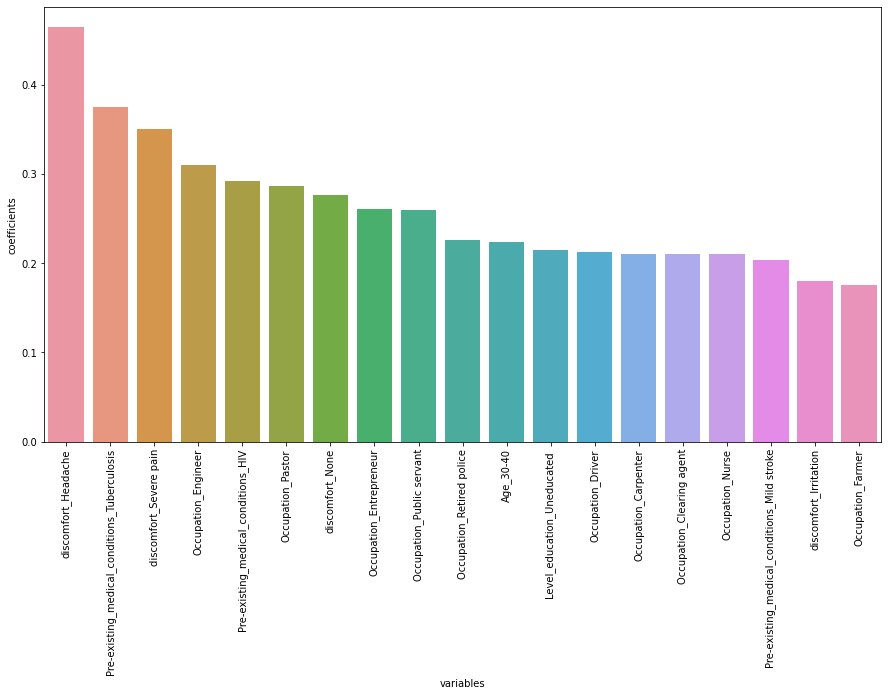

In [28]:
# I plot the variable importance 

fig = plt.figure(figsize=(15, 8))

t = sns.barplot(x=df_11.iloc[1:,0], y=df_11.iloc[1:,1])
plt.xticks(rotation=90)

varAnswer = df_11['variables'][df_11.iloc[:,1].abs() == df_11.iloc[:,1].abs().max()]

print('The variable that most influences the Patient waiting time is: {} \n'.format(varAnswer.iloc[0]))

In [29]:
#### Random Forest classifier 
rf = RandomForestClassifier(class_weight='balanced', max_depth=80, max_features=2,
                       min_samples_leaf=3, min_samples_split=10,
                       n_estimators=300)

##  Random Forest 
#hyper parameters set
params_rf = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [50, 100, 300]}

# Load GridSearchCV Random Forest  
cv_grid_rf = GridSearchCV(
    estimator=rf,
    param_grid=params_rf,
    n_jobs=-1,
    cv = cv,
    scoring=make_scorer(accuracy_score)
)

In [30]:
## Random Forest Model 
rf_model_cv  = cv_grid_rf.fit(X_train, y_train)

In [31]:
# Random Forest Best GridSearch CV Best score 
print('Random Forest Best GridSearch CV Score: ', rf_model_cv.best_score_)

Random Forest Best GridSearch CV Score:  0.6959401709401709


accuracy_score of the best classifier after CV is 74.194%
Test Accuracy score 0.7419354838709677
Test Matthews correlation coefficient 0.2991830368027063
Test F1- score 0.42857142857142855
Test Precision score 0.6
Test Recall score 0.3333333333333333
              precision    recall  f1-score   support

           0       0.77      0.91      0.83        22
           1       0.60      0.33      0.43         9

    accuracy                           0.74        31
   macro avg       0.68      0.62      0.63        31
weighted avg       0.72      0.74      0.72        31



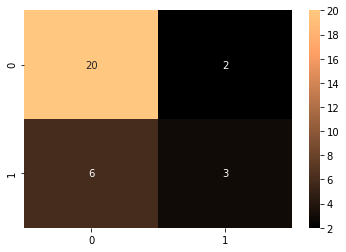

In [32]:
# Random Forest Classifier 
y_predict_rf = rf_model_cv.predict(X_test)

accuracy = accuracy_score(y_test,y_predict_rf)
print('accuracy_score of the best classifier after CV is %.3f%%' % (accuracy*100))

#Classification reports Random Forest 
print('Test Accuracy score %s' % accuracy_score(y_test, y_predict_rf))
print('Test Matthews correlation coefficient %s' % matthews_corrcoef(y_test, y_predict_rf))
print('Test F1- score %s' % f1_score(y_test, y_predict_rf))
print('Test Precision score %s' % precision_score(y_test, y_predict_rf))
print('Test Recall score %s' % recall_score(y_test, y_predict_rf))
print(classification_report(y_test, y_predict_rf))
confusion_matrix(y_test, y_predict_rf)
conf_matrix = confusion_matrix(y_test,y_predict_rf)
sns.heatmap(conf_matrix, annot=True,fmt='d', cmap=plt.cm.copper)
plt.show()

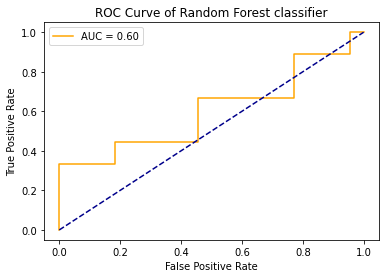

In [33]:
# Now plot the ROC curve for Logistic regression 
probs =  rf_model_cv.predict_proba(X_test)
probs = probs[:, 1]
auc1 = roc_auc_score(y_test, probs)
fpr1, tpr1, thresholds = roc_curve(y_test, probs)
def plot_roc_curve(fpr1, tpr1):
    plt.plot(fpr1, tpr1, color='orange', label = 'AUC = %0.2f' % auc1)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve of Random Forest classifier')
    plt.legend()
plot_roc_curve(fpr1, tpr1)
plt.show()

In [34]:
print(rf_model_cv.best_estimator_)

RandomForestClassifier(class_weight='balanced', max_depth=80, max_features=3,
                       min_samples_leaf=5, min_samples_split=10)


In [35]:
# Creating a table with the feature importances
clf = RandomForestClassifier(class_weight='balanced', max_depth=80, max_features=3,
                       min_samples_leaf=3, min_samples_split=12, n_estimators=50)
clf_rf = clf.fit(X_train, y_train)
feature_importances = pd.concat([
pd.DataFrame(df.drop(columns='sample_ID').
columns, columns = ['variables']),
pd.DataFrame(np.transpose(clf_rf.feature_importances_), 
columns = ["coefficients"])],axis = 1)
featImport = feature_importances.sort_values("coefficients", ascending = False)

In [36]:
df_11 = featImport.iloc[:20,:]

The variable that most influences the Patient waiting time is: Pre-existing_medical_conditions_Ulcer 



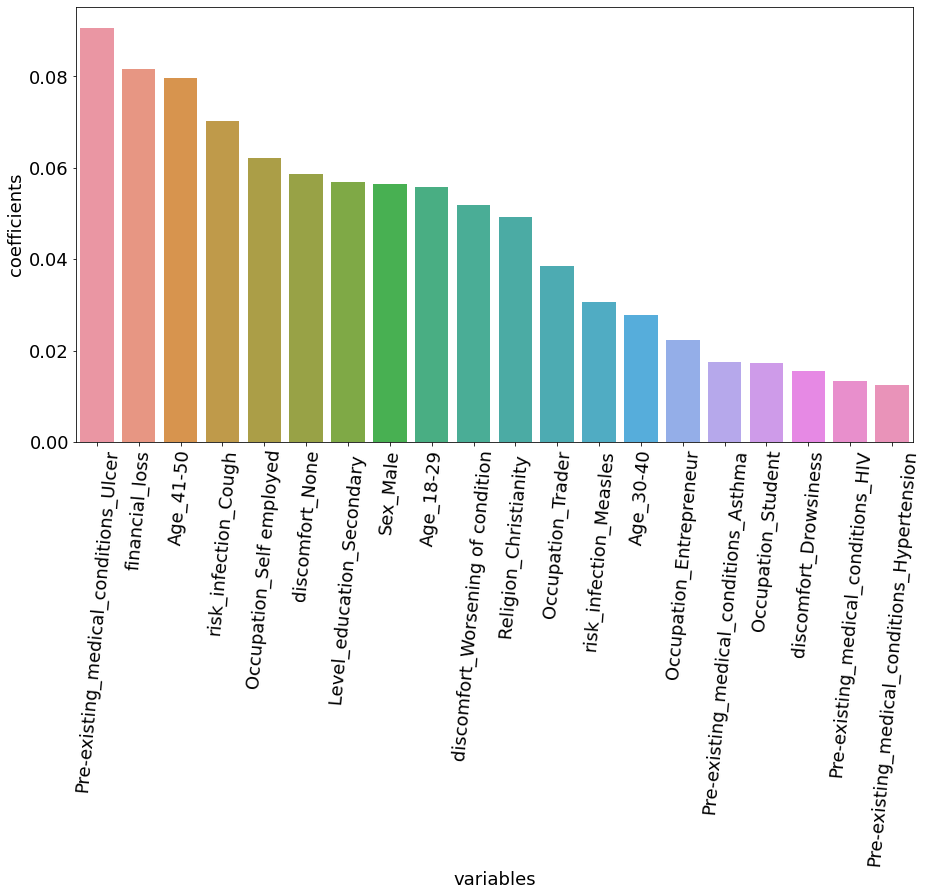

In [37]:
# I plot the variable importance 
plt.rc('font', size=18) 
fig = plt.figure(figsize=(15, 8))

t = sns.barplot(x=df_11.iloc[:,0], y=df_11.iloc[:,1])
plt.xticks(rotation=85)

varAnswer = df_11['variables'][df_11.iloc[:,1].abs() == df_11.iloc[:,1].abs().max()]

print('The variable that most influences the Patient waiting time is: {} \n'.format(varAnswer.iloc[0]))

#### Inferences and Interpretations 

- Generally the queuing model at the outpatient clinic is attended largely by young poplace around 18-29 years 
- Widows and divorced individuals rarely comes for treatment at the outpatient clinic 
- Individuals between the age range of 30 -40 are more likely to complain about the waiting time at the outpatient clinic 
- Majority of the patients are OK with the present waiting time in the system at the outpatient clinic.
- There is an association between religion and age, premedical condition and age, waiting time and level of education, discomfort and sex. 

- Since relationships tends to exist between the variables with none suffering from multicollinearity or some sorts of degree of causalty, we can proceed to model the dataset using machine learning algorithms. 

- Logistics Regression Model classified the dataset correctly with accuracy score of 68.74% (best 5-fold cross validation mean score) and external prediction acuracy score of 64.52%. The ROC_AUC score of 57%. The top 5-most importance feature coefficients include discomfort (headache), Pre-medical condition (Tuberculosis), discomfort (severe pain), occupation (Engineer), and pre-medical condition (HIV). 

- Random Forest model classifier correctly classfied the dataset with the accuracy score of 70.21% (best 5-fold cross validation mean score) and external prediction acuracy score of 74.19%. The ROC_AUC score of 59%. The top 5-most importance feature coefficients include pre-medical condition (ulcer), financial loss, age (41 -50 years), risk infection (cough), and occupation (self-employed). 

#### Conclusion

In this study, we incorporated financial cost and health-related risks into a queuing model at the outpatient clinic of a public hospital in Nigeria to optimize the patient waiting time. The findings from this study established that there are relationships between financial cost, health-related risks, and patient waiting time at the outpatient clinic. It is therefore, necessary to incorporate health-related risks into the queuing model to minimize the incidence rate and complications developed by patients in long waiting queues at healthcare facilities. This is important to help prioritize high-risk patients and increase their survival rate. 